In [26]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict

In [27]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
# h5py_file.visititems(printattr)

In [28]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    additional cuts (same as CMS) https://docs.google.com/presentation/d/1BQMzvTOqzOXAut0Fa0nzlKAYolAnuIf95hQ0uUq7qZU/edit#slide=id.g158289c3298_0_168 P3
    """
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    delR = np.array([np.sqrt((jet_eta[i] - lepton_eta[i])**2 + (jet_phi[i] - lepton_phi[i])**2) for i in range(len(jet_eta))])
    
    cut_reco_top = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    # pid 11 is electron, 13 is muon.
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 4] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2

    # cuts = cut_reco_top
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(right, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)

    
    for key in dic: dic[key] = dic[key][cuts]
    state = state[cuts]
    if target == 'klfitter':
        return dic['reconstructed_top_mass'], state, h5py_file['klfitter/score/loglikelihood'][:][cuts]
    else:
        return dic['reconstructed_top_mass'], state

In [29]:
# The reco_top_mss from ttbar_testing_mass_variation
mass = [170, 171, 172, 173, 174, 175, 176]
state_labels = ['Unmatched', 'Incorrect', 'Correct']

reco_spanet_dic = {}
reco_klf_dic = {}
reco_target_dic = {}

state_spanet_dic = {} # 0 for unmatched, 1 for incorrect, 2 for correct
state_klf_dic = {}
state_target_dic = {}

loglikeli_klf_dic = {}

for m in mass:
    h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
    reco_spanet_dic[m], state_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_klf_dic[m], state_klf_dic[m], loglikeli_klf_dic[m]  = get_reco_top_mass(h5py_file, 'klfitter')
    reco_target_dic[m], state_target_dic[m] = get_reco_top_mass(h5py_file, 'target')

/tmp/ipykernel_28766/2017995895.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


In [30]:
# Fixed the bins, colors, and tot_event for all plots.
bins = np.arange(100, 301, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
tot_event = 100000

In [31]:
h5py_file = h5py.File('ttbar_testing_sm/ttbar_testing_sm.h5', "r")
reco_spanet, state_spanet = get_reco_top_mass(h5py_file, 'spanet')

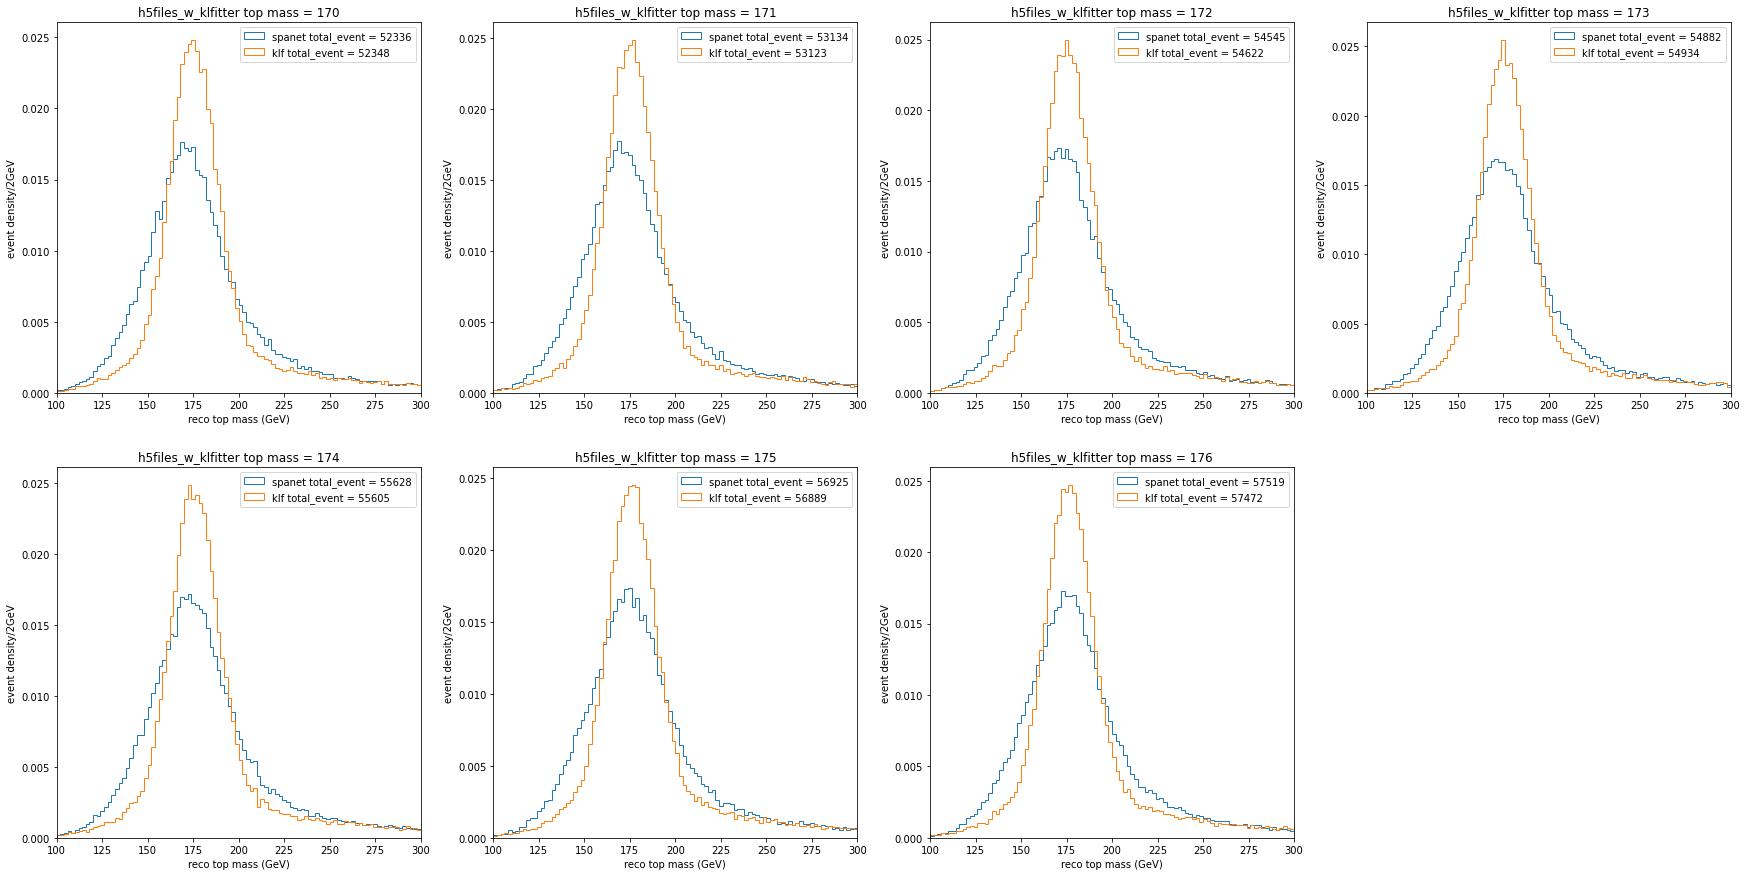

In [32]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(reco_spanet_dic[m], bins=bins, density=True, histtype='step', label='spanet total_event = ' + str(len(reco_spanet_dic[m])))
    plt.hist(reco_klf_dic[m], bins=bins, density=True, histtype='step', label='klf total_event = ' + str(len(reco_klf_dic[m])))
    plt.title('h5files_w_klfitter top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event density/2GeV')
    plt.legend(loc='upper right')
plt.show()

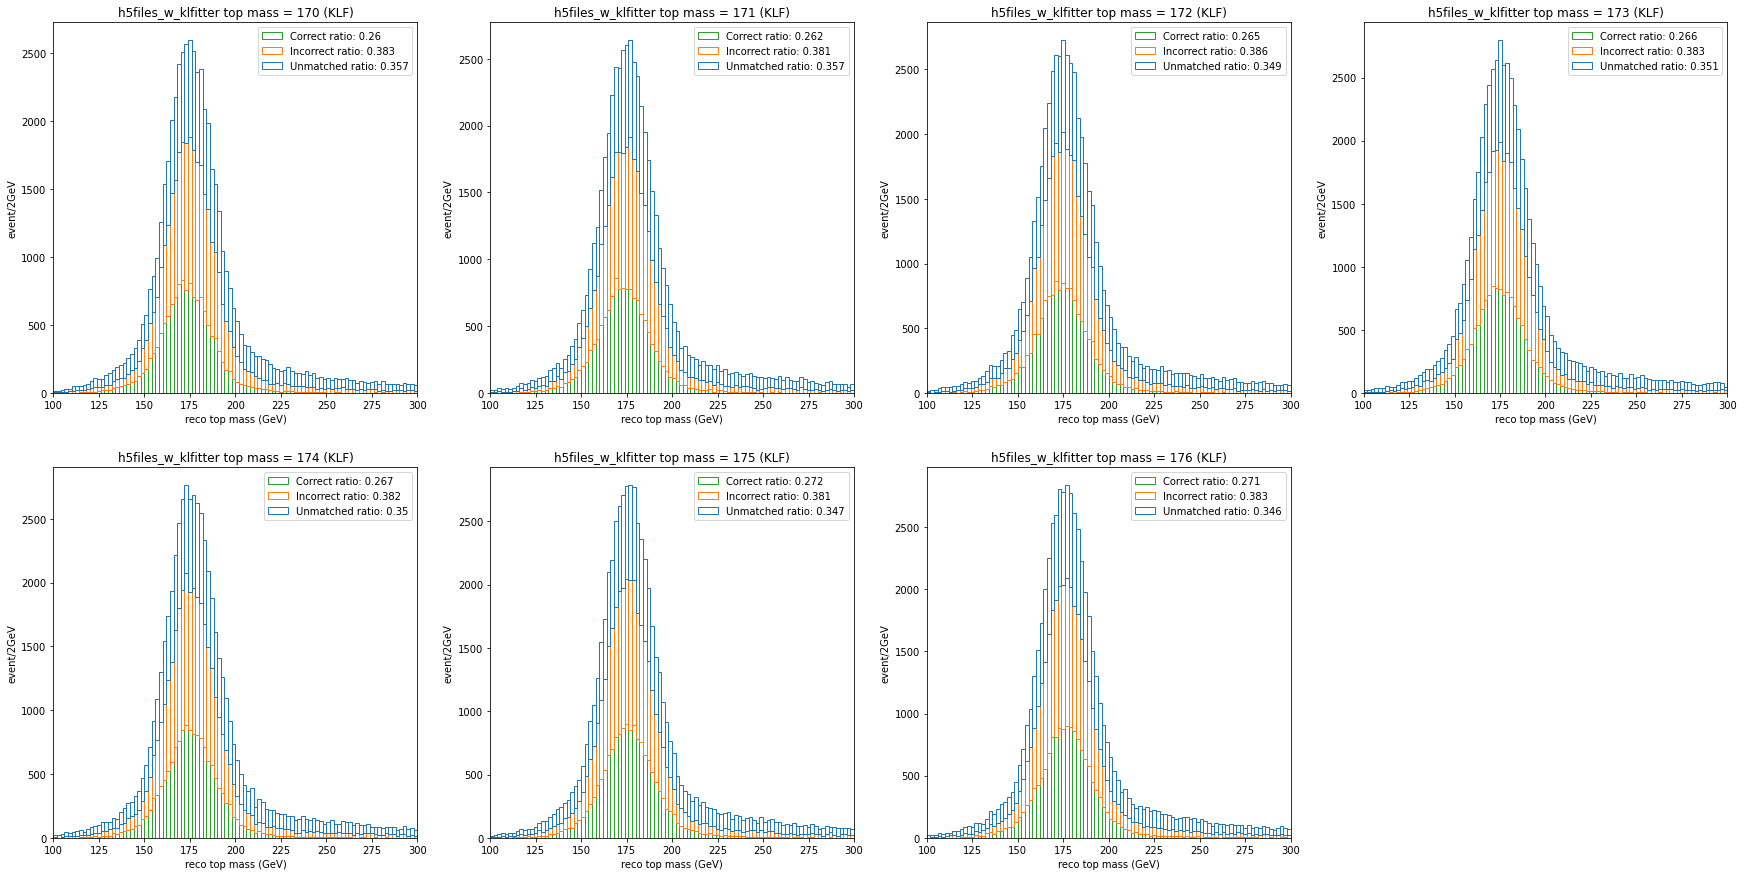

In [33]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_klf_dic[m]==i)/len(state_klf_dic[m])
        hist, bin_edges = np.histogram(reco_klf_dic[m][state_klf_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+1, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (KLF)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

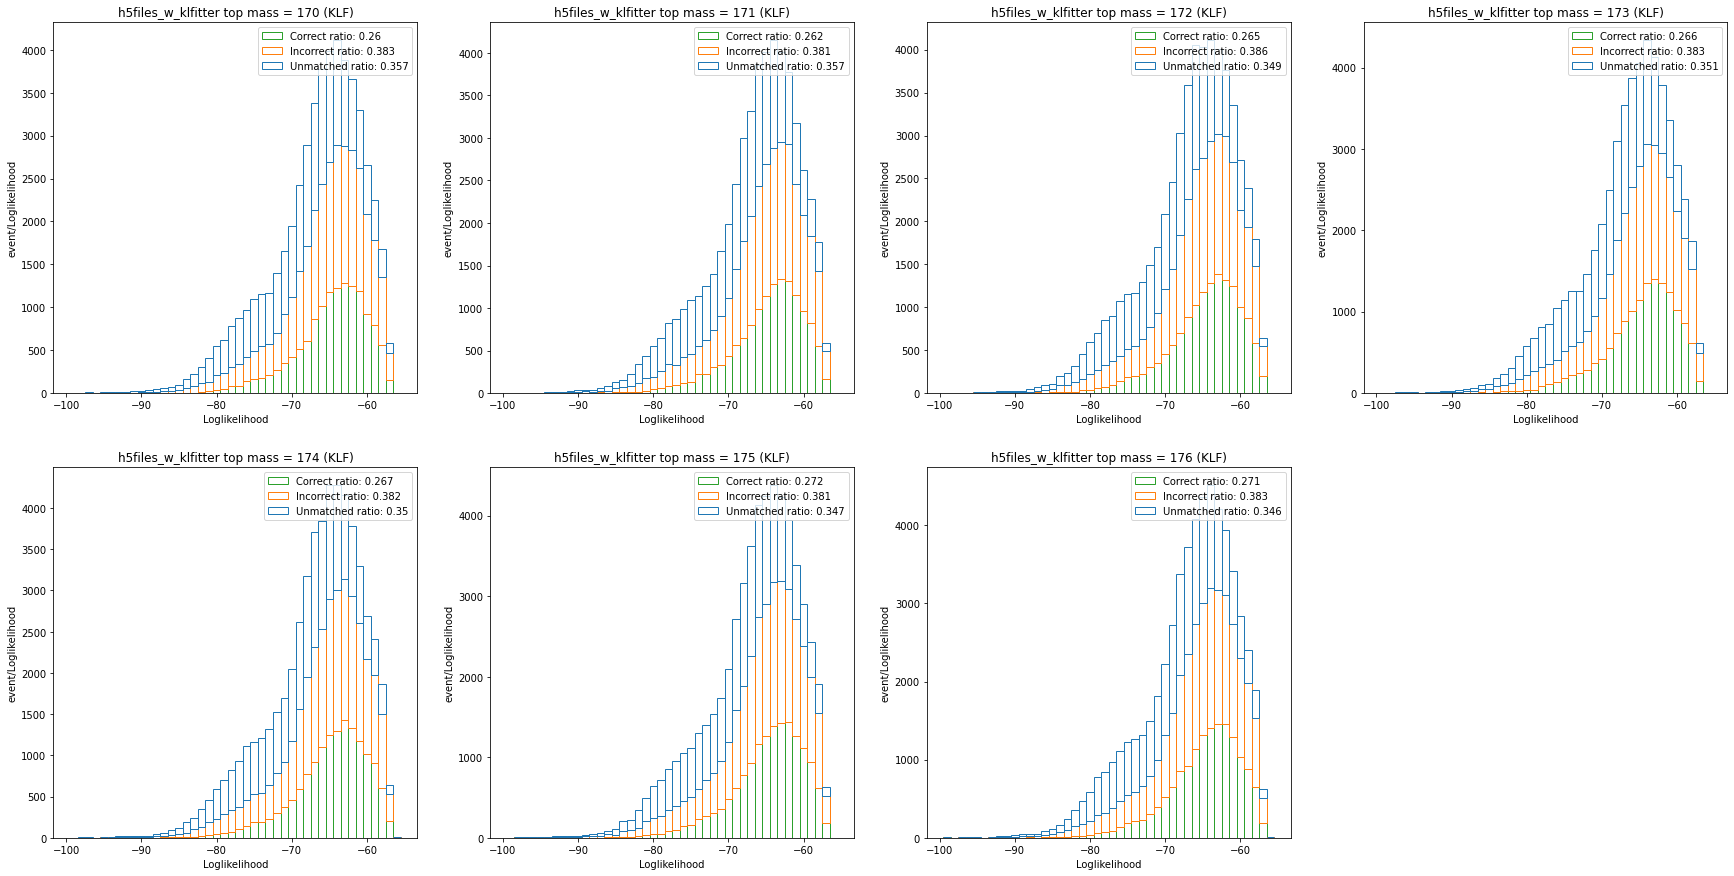

In [34]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*44
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_klf_dic[m]==i)/len(state_klf_dic[m])
        hist, bin_edges = np.histogram(loglikeli_klf_dic[m][state_klf_dic[m] == i], bins=np.arange(-100, -55, 1))
        plt.bar(bin_edges[:-1]+1, hist, bottom=h, edgecolor=colors[i], width=1, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (KLF)'.format(m))
    plt.xlabel('Loglikelihood')
    plt.ylabel('event/Loglikelihood')
    plt.legend(loc='upper right')
plt.show()

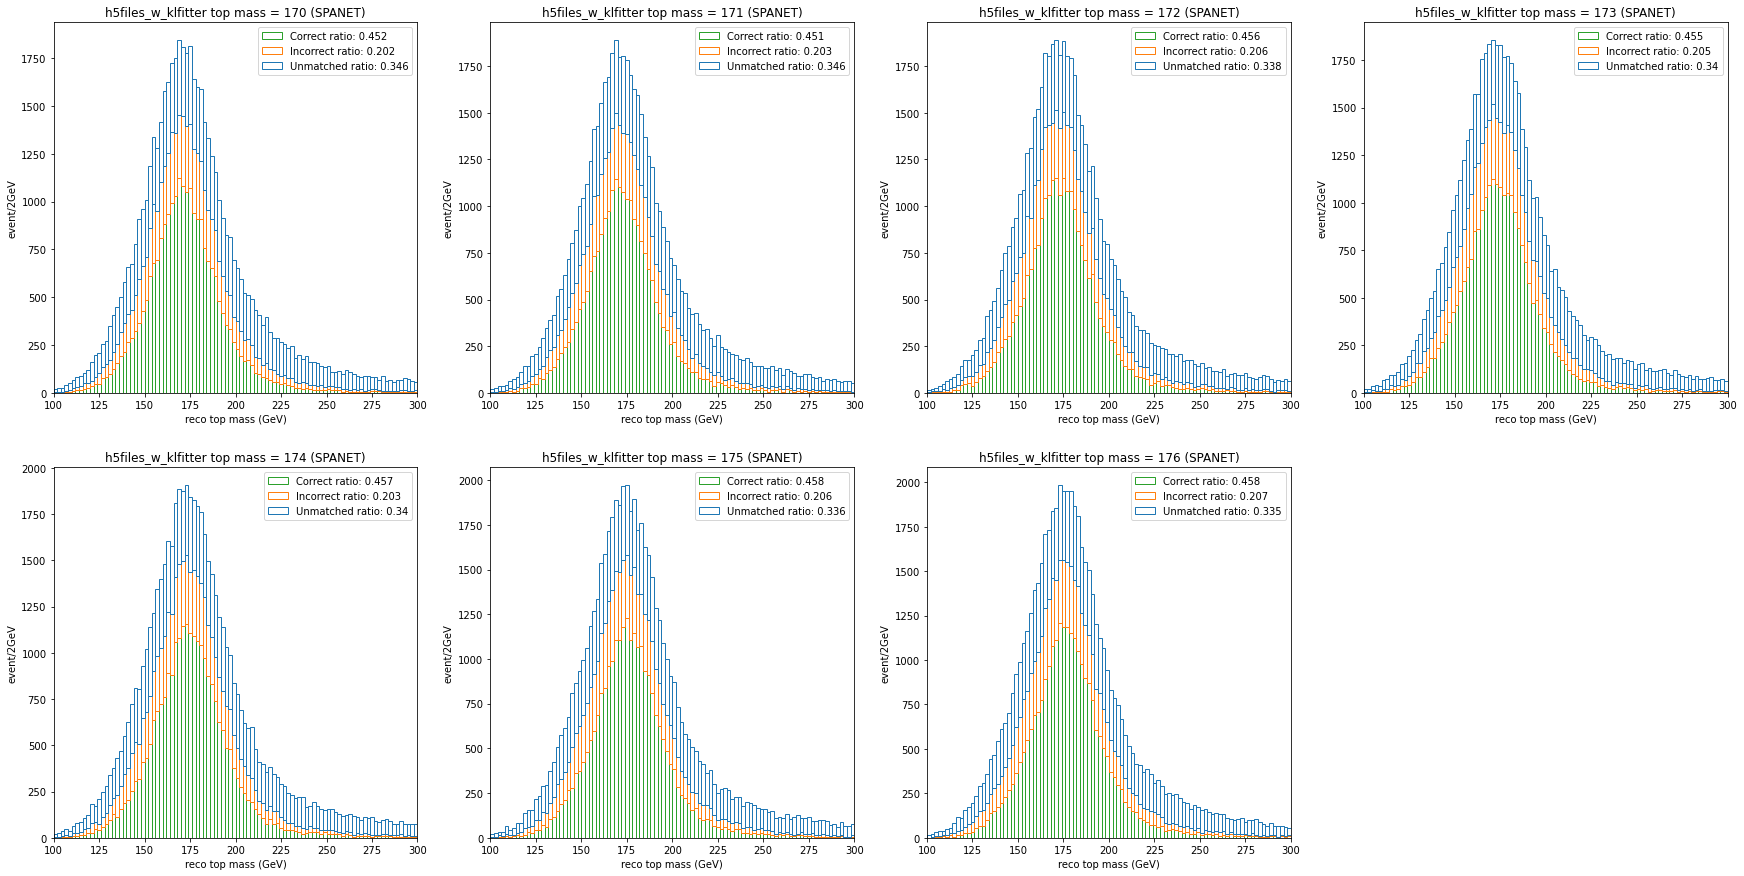

In [35]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_spanet_dic[m]==i)/len(state_spanet_dic[m])
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+1, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (SPANET)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

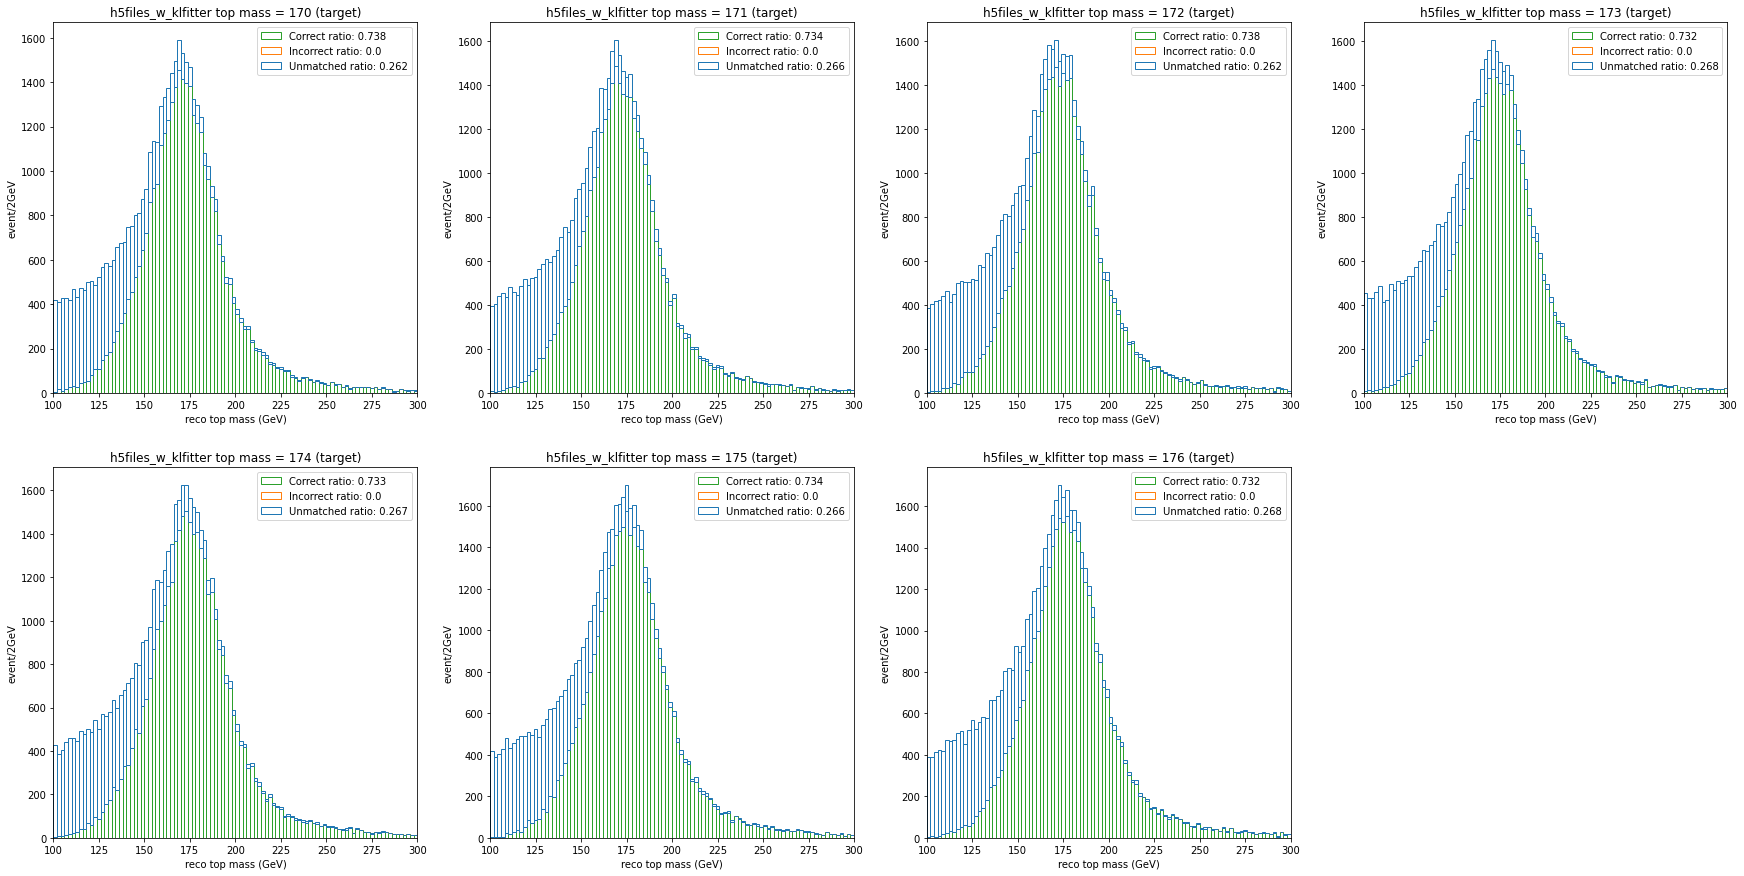

In [36]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    h = [0]*(len(bins)-1)
    
    for i in [2, 1, 0]:
        ratio = np.count_nonzero(state_target_dic[m]==i)/len(state_target_dic[m])
        hist, bin_edges = np.histogram(reco_target_dic[m][state_target_dic[m] == i], bins=bins)
        plt.bar(bin_edges[:-1]+1, hist, bottom=h, edgecolor=colors[i], width=2, color='None', label = state_labels[i] + ' ratio: ' + str(round(ratio, 3)))
        h += hist
    plt.title('h5files_w_klfitter top mass = {} (target)'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

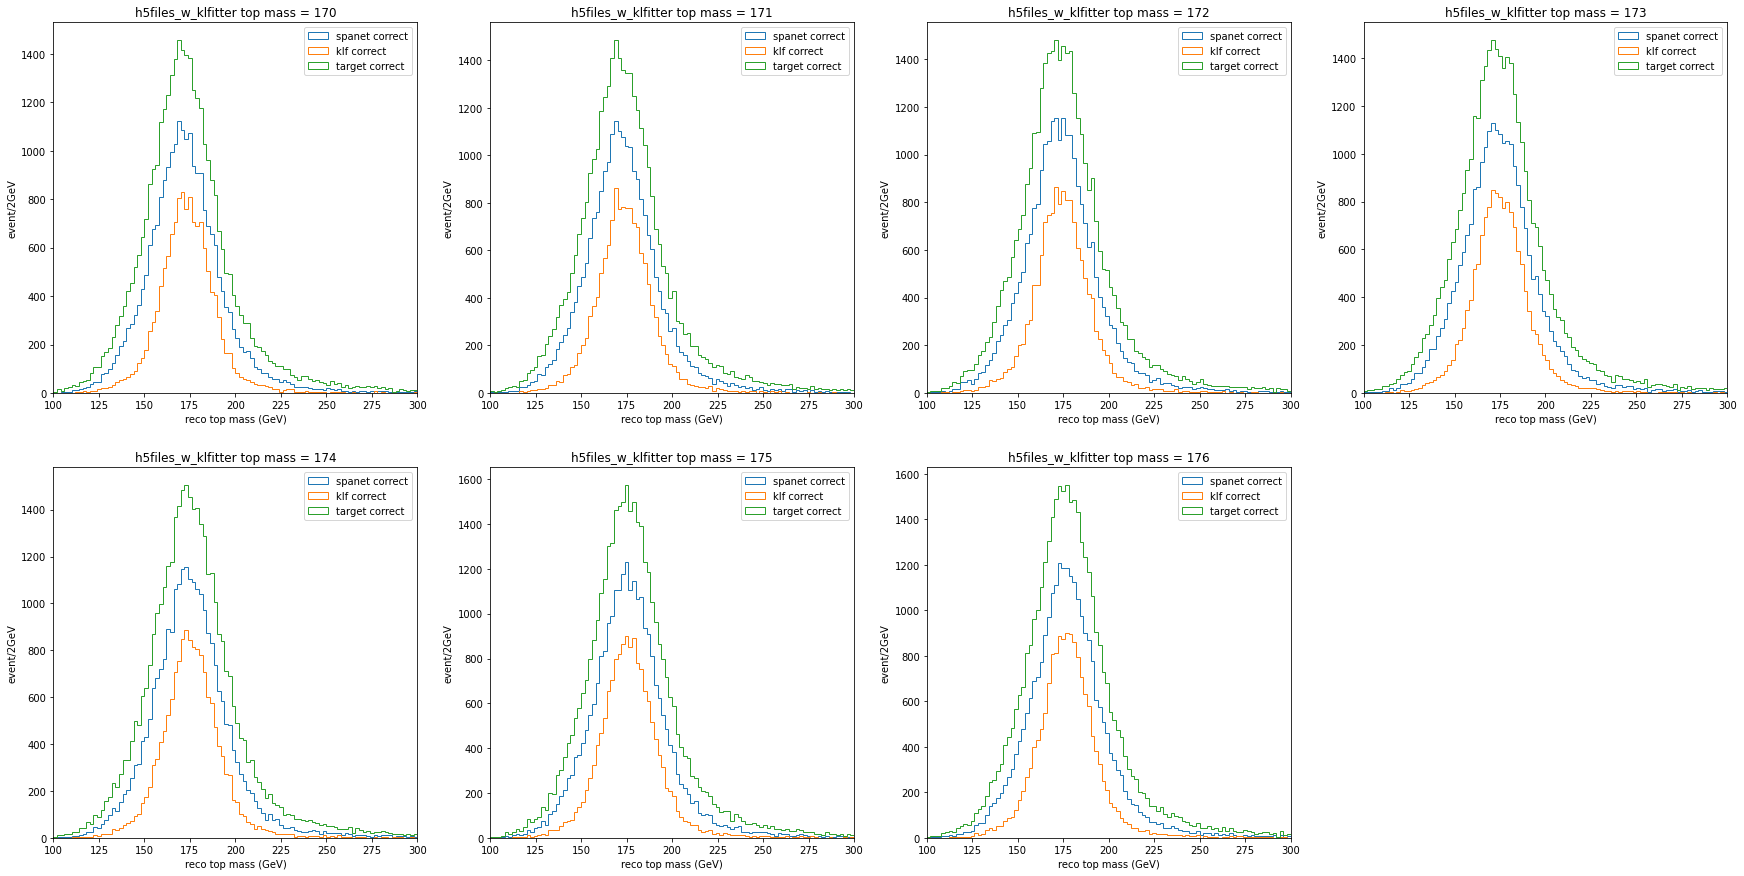

In [37]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(reco_spanet_dic[m][state_spanet_dic[m] == 2], bins=bins, histtype='step', label='spanet correct')
    plt.hist(reco_klf_dic[m][state_klf_dic[m] == 2], bins=bins, histtype='step', label='klf correct')
    plt.hist(reco_target_dic[m][state_target_dic[m] == 2], bins=bins, histtype='step', label='target correct')
    plt.title('h5files_w_klfitter top mass = {}'.format(m))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/2GeV')
    plt.legend(loc='upper right')
plt.show()

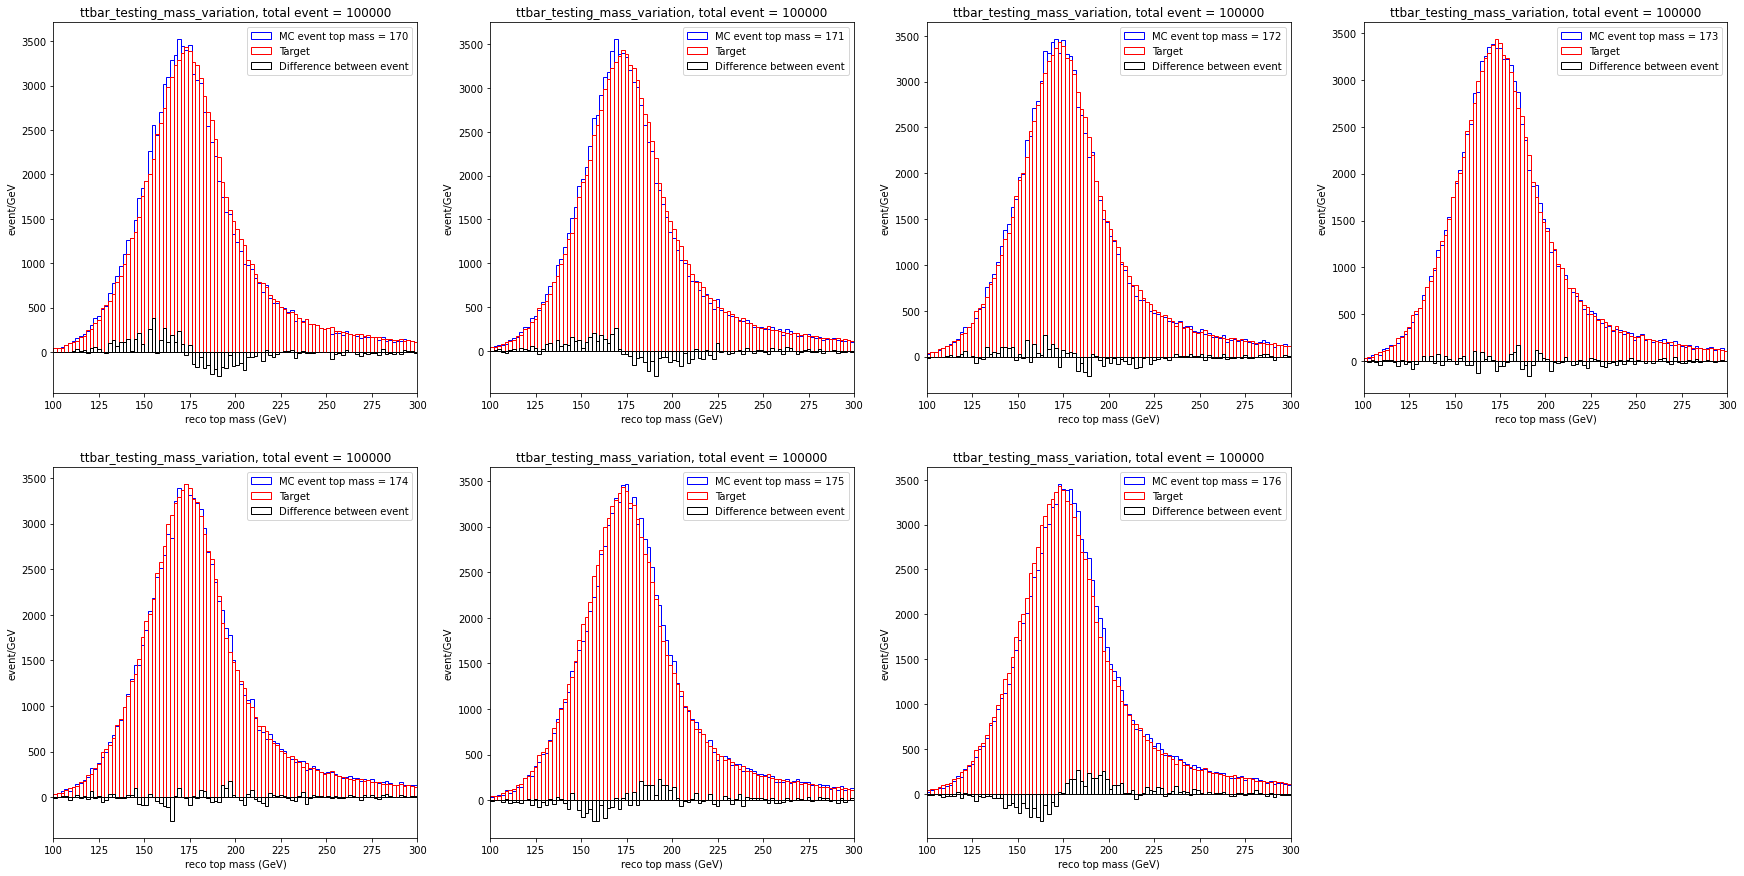

In [38]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    hist1, bin_edges = np.histogram(reco_spanet_dic[m], bins=bins)
    hist1 = hist1*tot_event/sum(hist1)
    hist2, bin_edges = np.histogram(reco_spanet, bins=bins)
    hist2 = hist2*tot_event/sum(hist2)
    plt.bar(bin_edges[:-1]+1, hist1, edgecolor='blue', width=2, color='None', label = 'MC event top mass = {}'.format(m))
    plt.bar(bin_edges[:-1]+1, hist2, edgecolor='red', width=2, color='None', label = 'Target')
    plt.bar(bin_edges[:-1]+1, hist1-hist2, edgecolor='black', width=2, color='None', label = 'Difference between event')
    plt.title('ttbar_testing_mass_variation, total event = {}'.format(tot_event))
    plt.xlim(100, 300)
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc='upper right')
plt.show()

In [39]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized version
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
def langau(x, lan_size, lan_loc, lan_scale, gau_size, gau_loc, gau_scale):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return lan_size*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + gau_size*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized landau distribution.
def lan_norm(x, lan_loc, lan_scale):
    lan_y = (x-lan_loc)/lan_scale
    return np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale

# One gaussian distribution.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Two gaussian distributions.
def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

# Linear
def linear(x, a, b):
    return a*x+b

In [40]:
def chi2_pdf(mt1, n2): #mt1 is the observation, n2 is the height of the bins from pdf.
    n1, _ = np.histogram(mt1, bins=bins)
    n2 *= 2*len(mt1)
    chi2_value = 2*sum([n2[i] - n1[i] + n1[i]*np.log(n1[i]/n2[i]) if n1[i]!=0 else n2[i] for i in range(len(n1))])
    return chi2_value

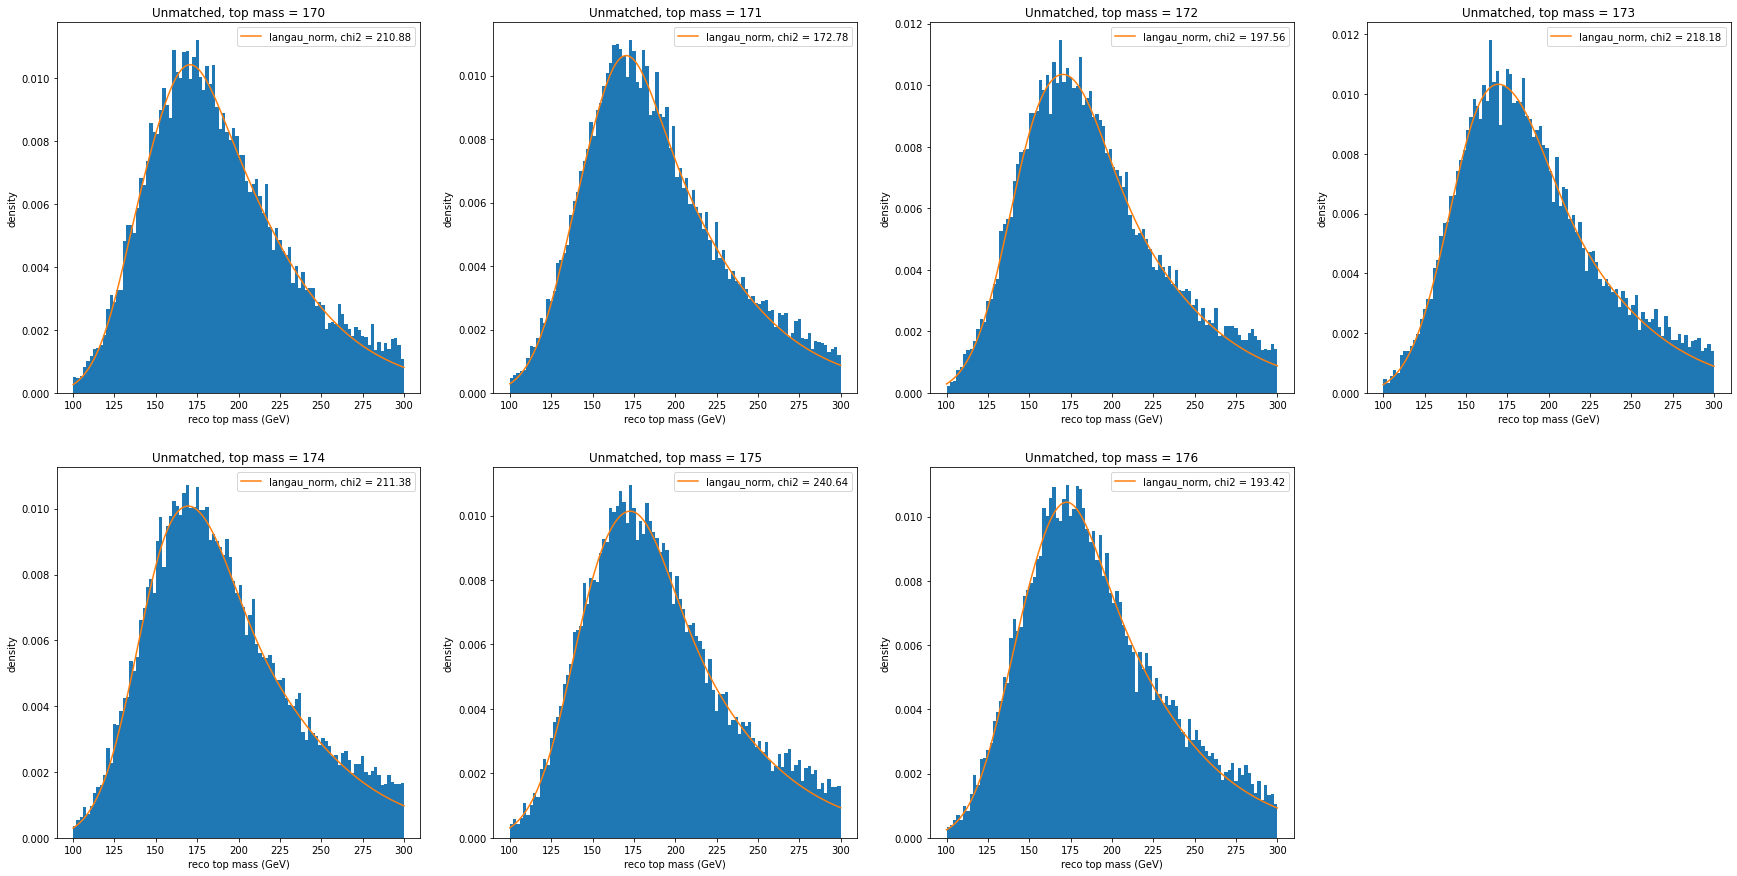

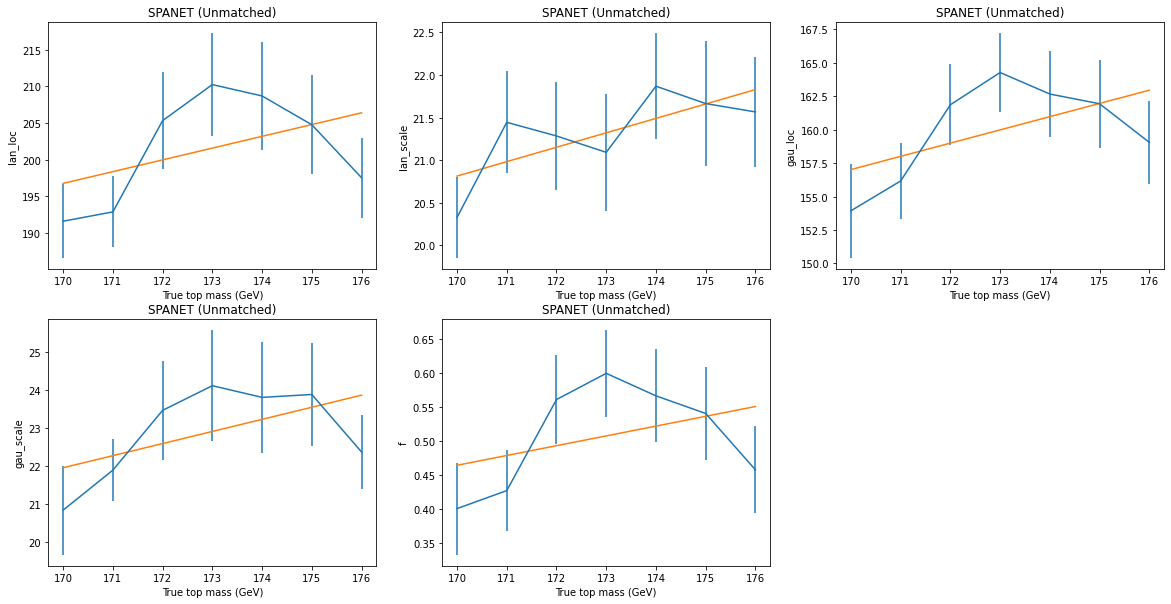

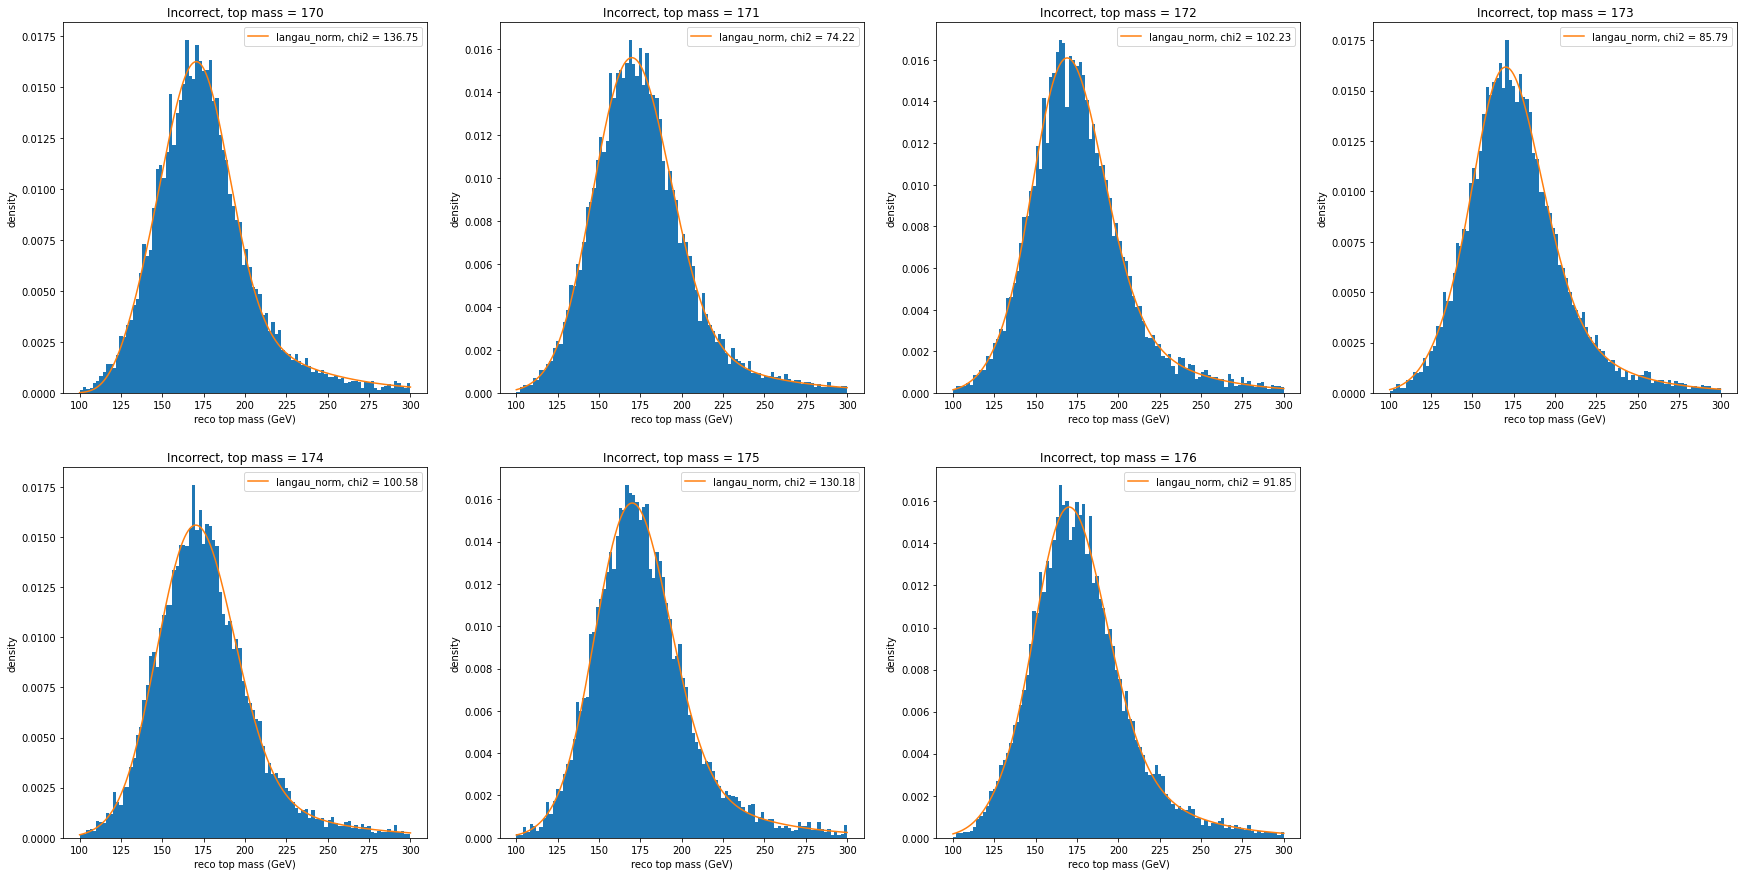

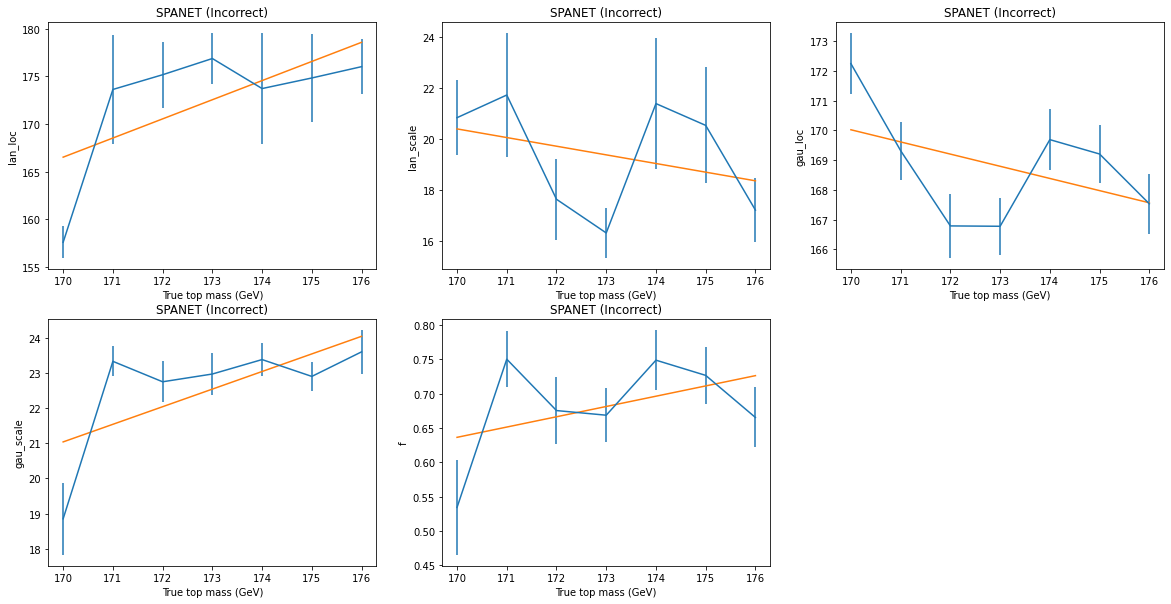

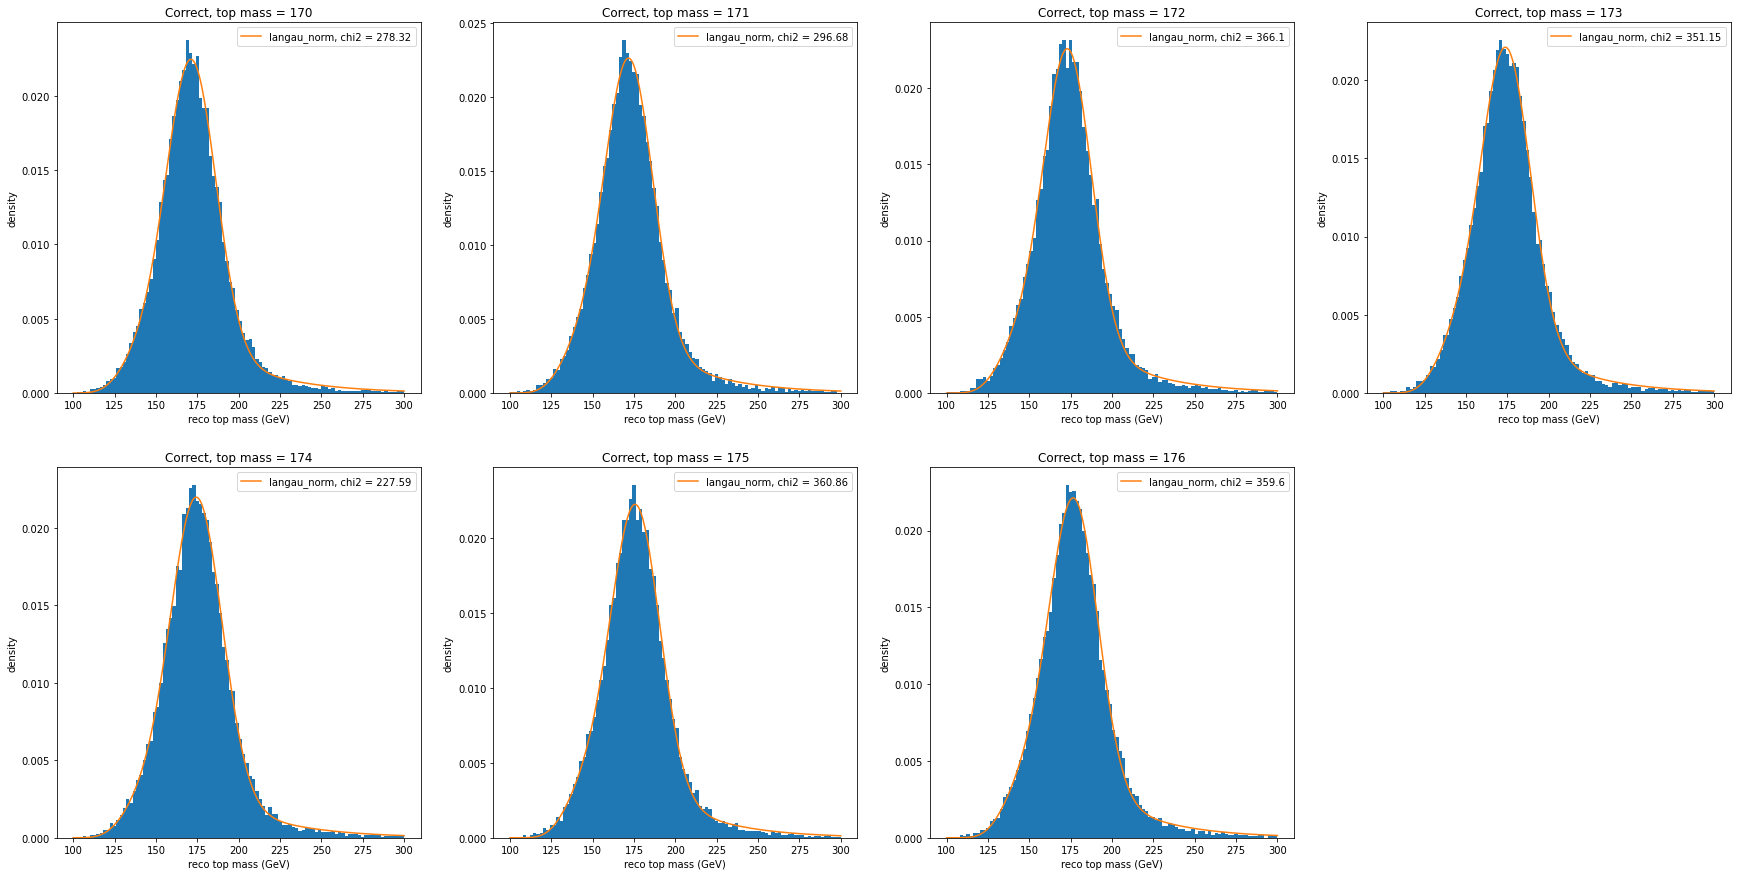

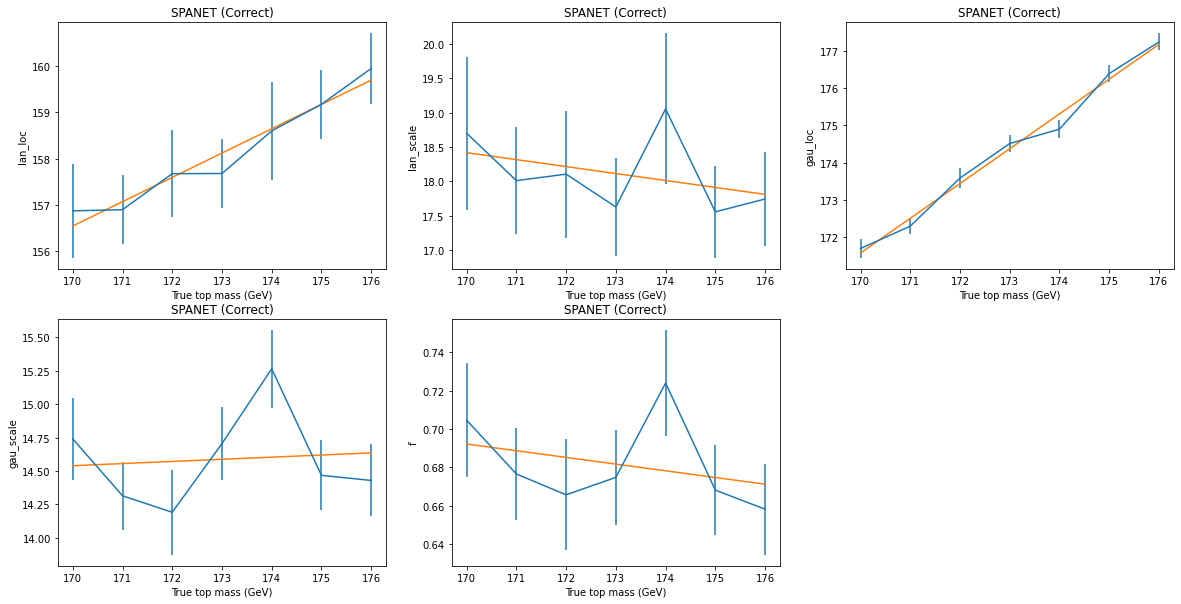

In [51]:
# Fit every class to landau gaussian
fita_spanet_dic, fitb_spanet_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}
bin_x = np.linspace(100, 300, 1000)

for state_i in [0, 1, 2]:
    popt_spanet_arr = []
    perr_spanet_arr = []
    popt_klf_arr = []
    
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        popt, pcov = optimize.curve_fit(langau_norm, bin_edges[:-1]+1, hist,
                                        p0=(150, 20, 160, 20, 0.9), bounds=((140, 10, 140, 10, 0), (250, 30, 250, 30, 1)))
        popt_spanet_arr.append(popt)
        perr = np.sqrt(np.diag(pcov))
        perr_spanet_arr.append(perr)
        y_langau_norm = langau_norm(bin_x, popt[0], popt[1], popt[2], popt[3], popt[4])
        chi_langau_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], langau_norm(bins[:-1]+1, popt[0], popt[1], popt[2], popt[3], popt[4]))
        plt.hist(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        plt.plot(bin_x, y_langau_norm, label='langau_norm, chi2 = {}'.format(round(chi_langau_norm, 2)))
        plt.title(state_labels[state_i] + ', top mass = {}'.format(m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()
    
    fit_labels = ['lan_loc', 'lan_scale', 'gau_loc', 'gau_scale', 'f']
    x = np.linspace(170, 176, 100)

    popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    fit_popt_dic[state_i] = popt_spanet_arr
    perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    fita_spanet_arr, fitb_spanet_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_spanet_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_spanet_arr[i])
        y = linear(x, popt[0], popt[1])
        plt.plot(x, y)
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(fit_labels[i])
        plt.title('SPANET ({})'.format(state_labels[state_i]))
        fita_spanet_arr.append(popt[0])
        fitb_spanet_arr.append(popt[1])
    plt.show()
    fita_spanet_dic[state_i] = fita_spanet_arr
    fitb_spanet_dic[state_i] = fitb_spanet_arr


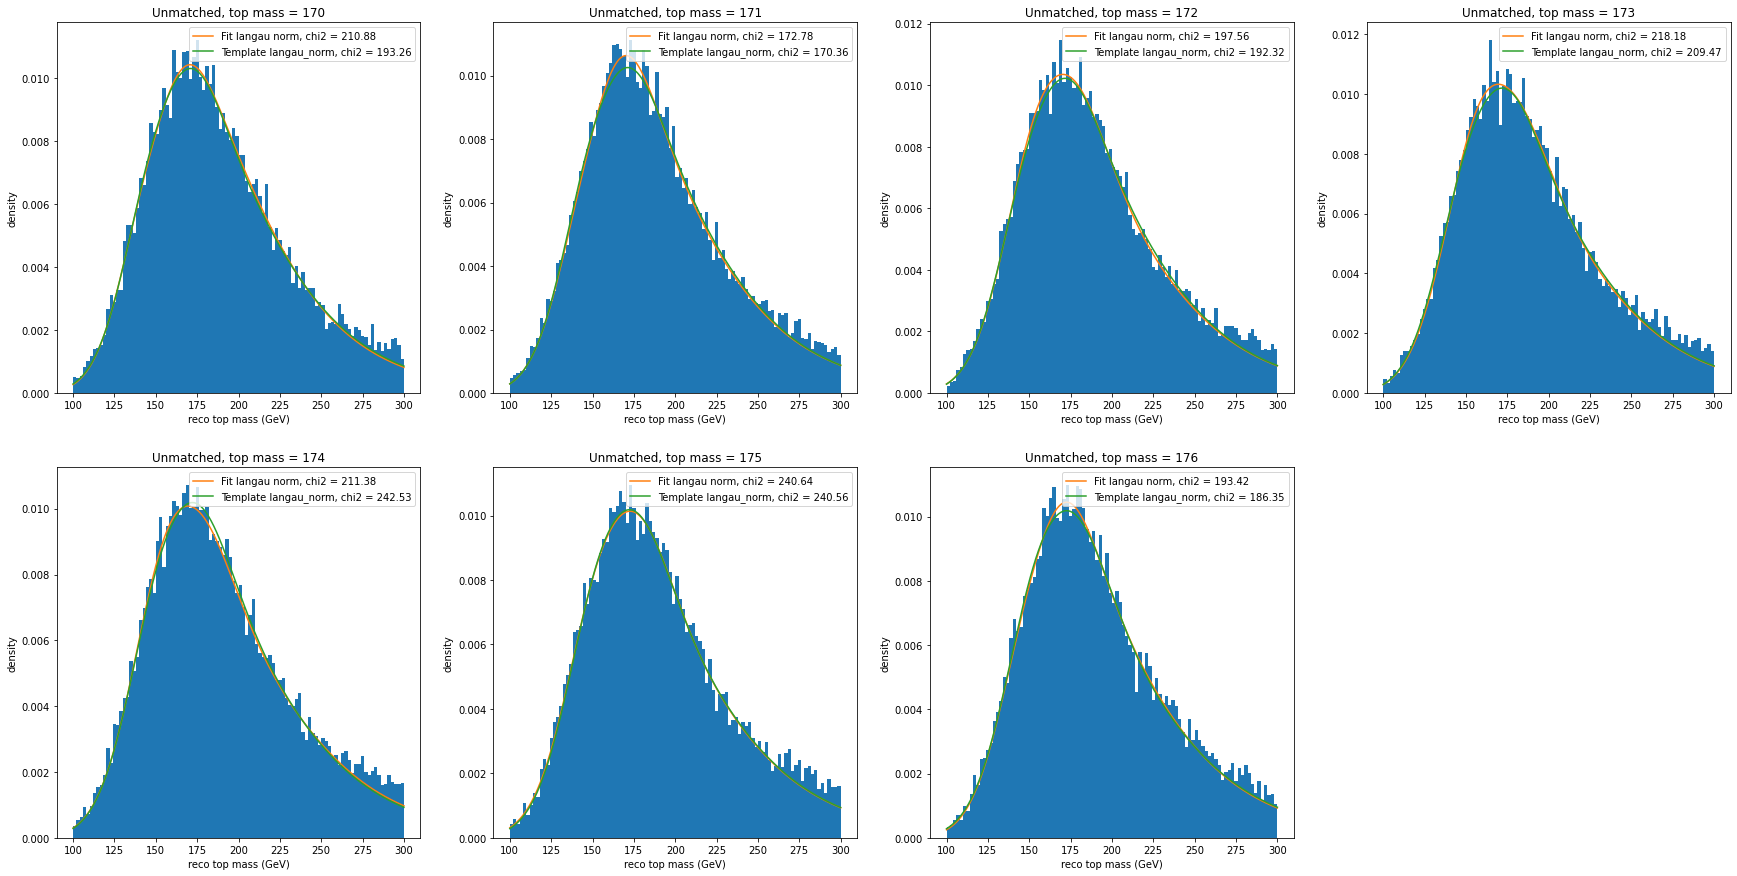

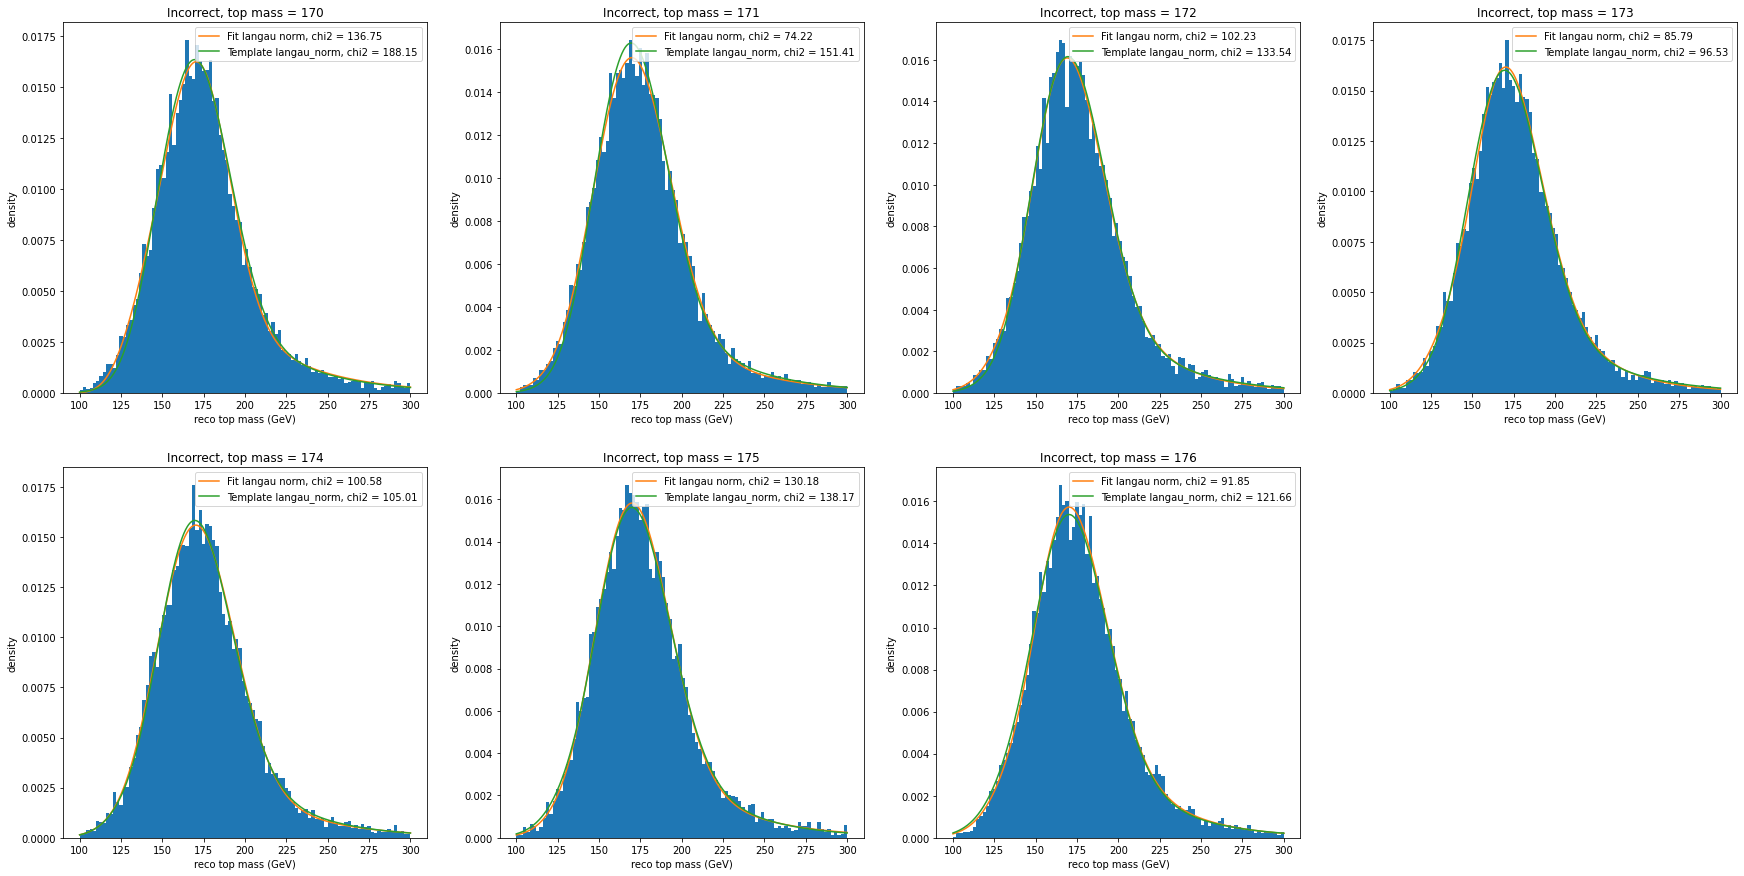

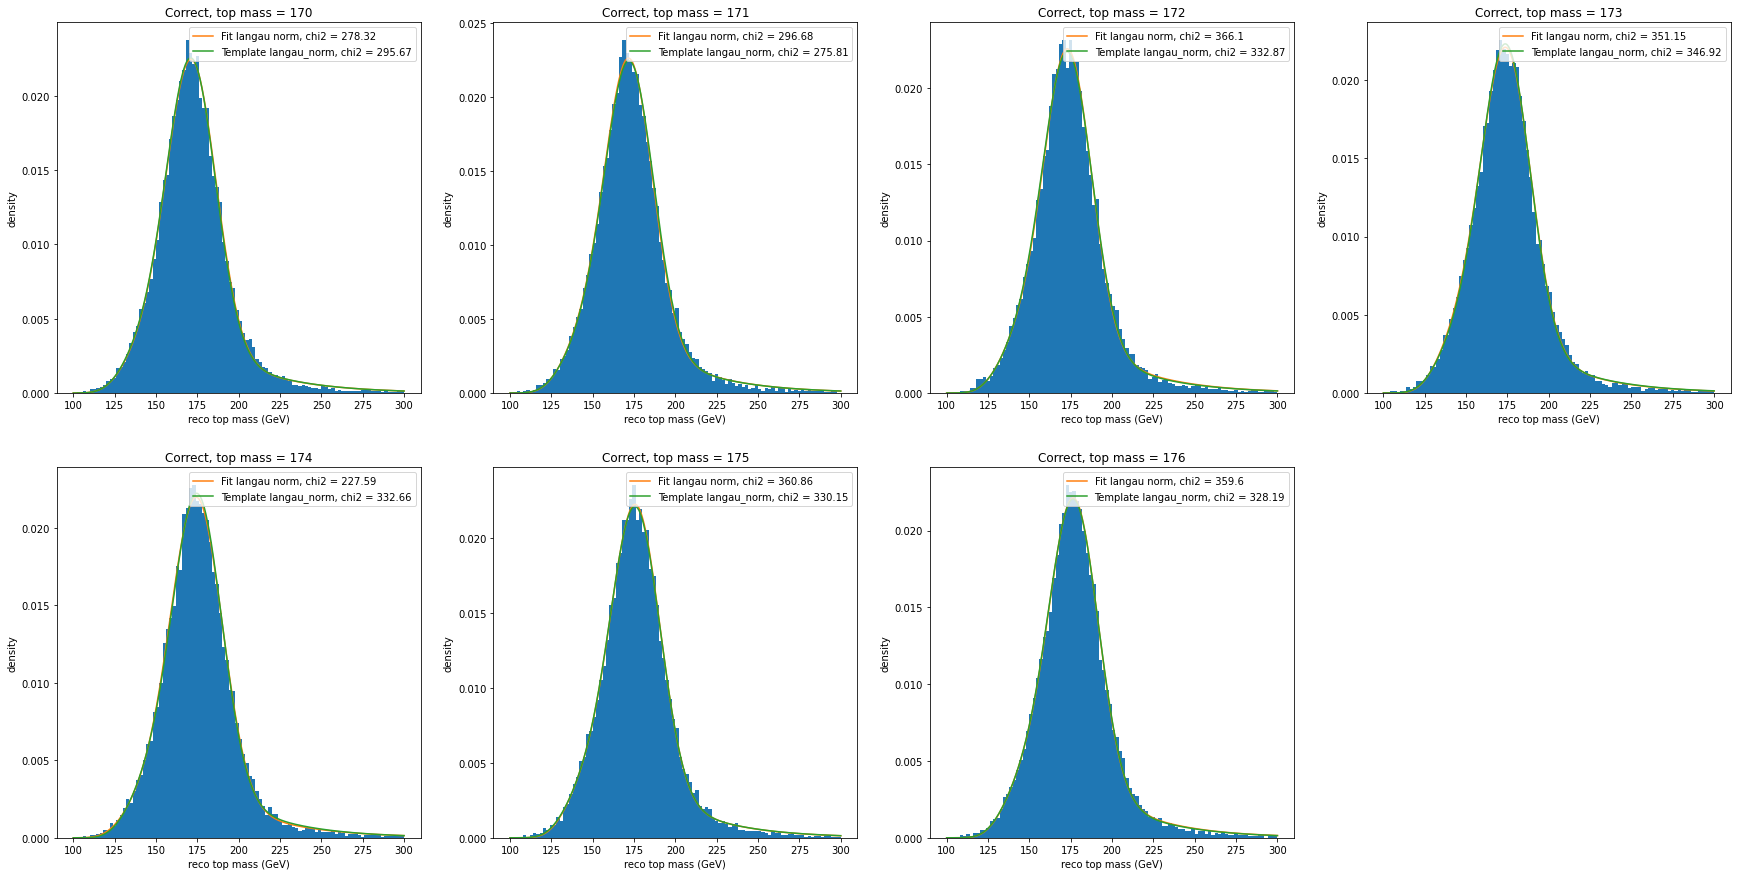

In [44]:
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        y_fit_norm = langau_norm(bin_x, fit_popt_dic[state_i][0, i], fit_popt_dic[state_i][1, i], fit_popt_dic[state_i][2, i], fit_popt_dic[state_i][3, i], fit_popt_dic[state_i][4, i])
        chi_langau_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], langau_norm(bins[:-1]+1, fit_popt_dic[state_i][0, i], fit_popt_dic[state_i][1, i], fit_popt_dic[state_i][2, i], fit_popt_dic[state_i][3, i], fit_popt_dic[state_i][4, i]))
        y_template_dense_norm = langau_norm(bin_x,
                            fita_spanet_dic[state_i][0]*m+fitb_spanet_dic[state_i][0],
                            fita_spanet_dic[state_i][1]*m+fitb_spanet_dic[state_i][1],
                            fita_spanet_dic[state_i][2]*m+fitb_spanet_dic[state_i][2],
                            fita_spanet_dic[state_i][3]*m+fitb_spanet_dic[state_i][3],
                            fita_spanet_dic[state_i][4]*m+fitb_spanet_dic[state_i][4])

        y_template_norm = langau_norm(bins[:-1]+1,
                                    fita_spanet_dic[state_i][0]*m+fitb_spanet_dic[state_i][0],
                                    fita_spanet_dic[state_i][1]*m+fitb_spanet_dic[state_i][1],
                                    fita_spanet_dic[state_i][2]*m+fitb_spanet_dic[state_i][2],
                                    fita_spanet_dic[state_i][3]*m+fitb_spanet_dic[state_i][3],
                                    fita_spanet_dic[state_i][4]*m+fitb_spanet_dic[state_i][4])
        chi_template_norm = chi2_pdf(reco_spanet_dic[m][state_spanet_dic[m]==state_i], y_template_norm)

        plt.hist(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)
        plt.plot(bin_x, y_fit_norm, label='Fit langau norm, chi2 = {}'.format(round(chi_langau_norm, 2)))
        plt.plot(bin_x, y_template_dense_norm, label='Template langau_norm, chi2 = {}'.format(round(chi_template_norm, 2)))
        plt.title(state_labels[state_i] + ', top mass = {}'.format(m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

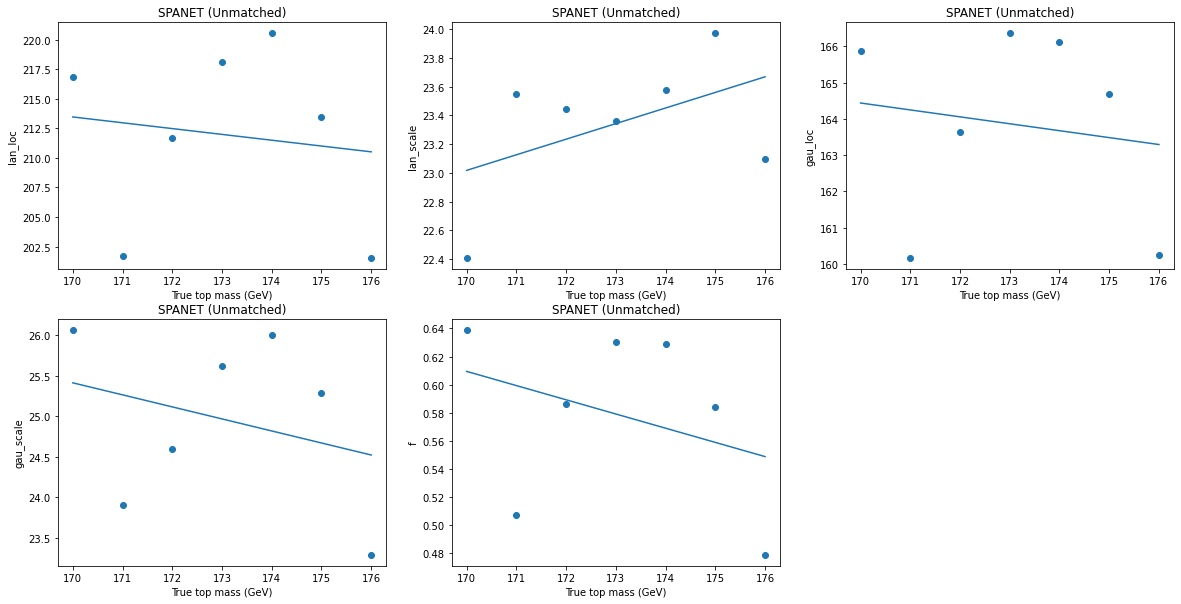

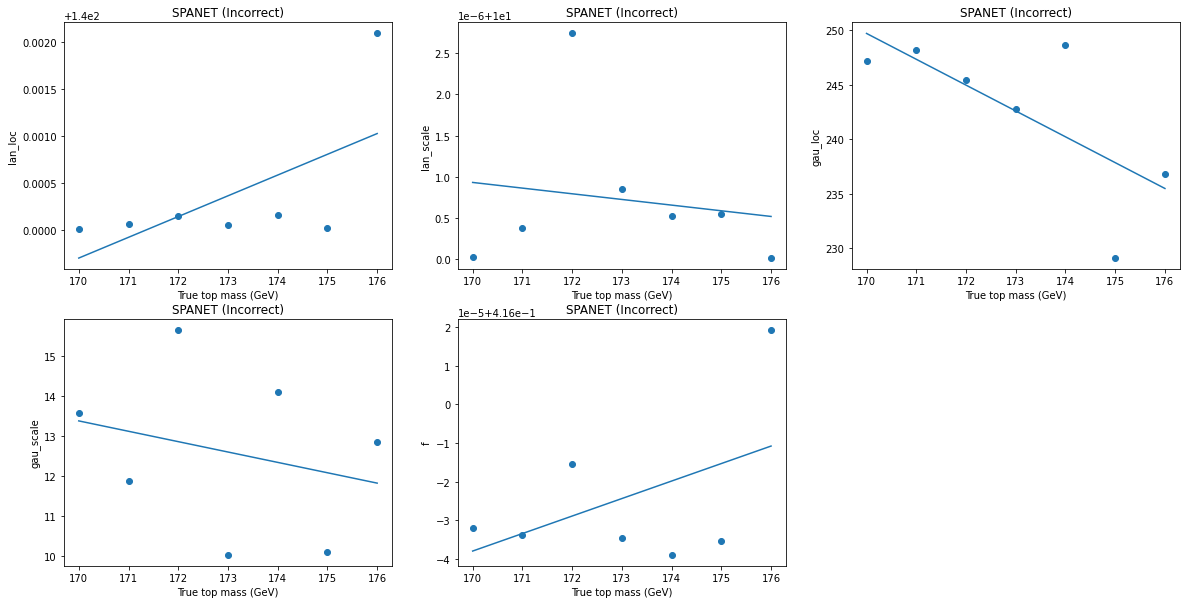

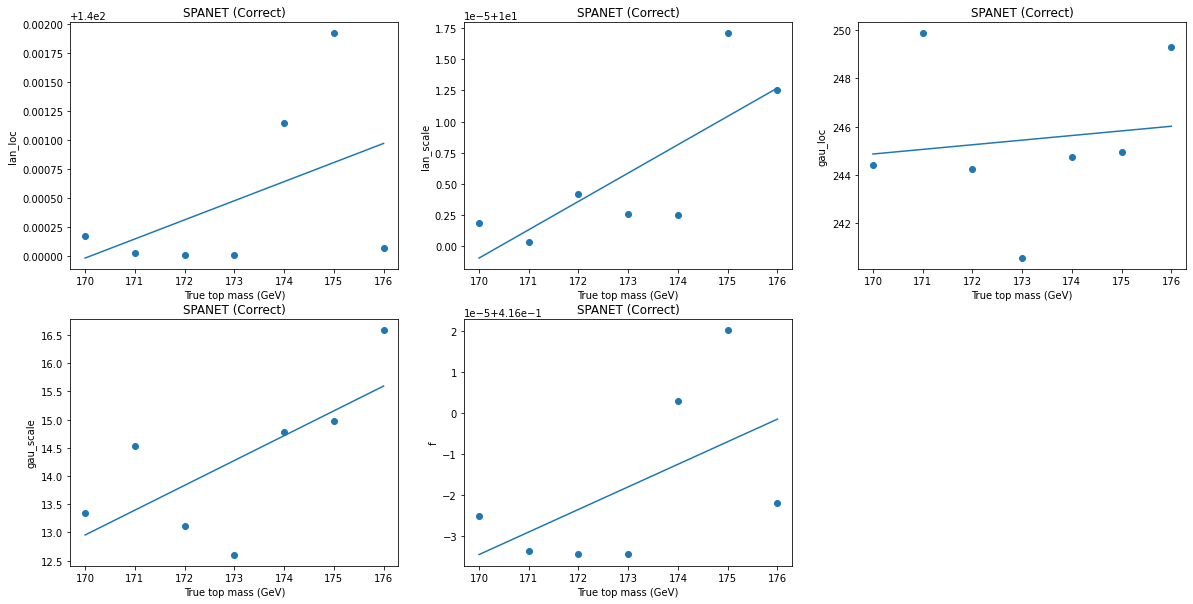

In [54]:
import lmfit
def resid(params, x, y_data):
    lan_loc = params['lan_loc'].value
    lan_scale = params['lan_scale'].value
    gau_loc = params['gau_loc'].value
    gau_scale = params['gau_scale'].value
    f = params['f'].value
    y_model = langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f)
    return 2*sum([y_model[i] - y_data[i] + y_data[i]*np.log(y_data[i]/y_model[i]) if y_data[i] != 0 else y_model[i] for i in range(100)])

x = bins[:-1]+1
keys = ['lan_loc', 'lan_scale', 'gau_loc', 'gau_scale', 'f']
for state_i in [0, 1, 2]:
    d = defaultdict(list)
    for m in mass:
        hist, bin_edges = np.histogram(reco_spanet_dic[m][state_spanet_dic[m]==state_i], bins=bins, density=True)

        params = lmfit.Parameters()
        params.add('lan_loc', 200, min=140, max=250)
        params.add('lan_scale', 20, min=10, max=30)
        params.add('gau_loc', 200, min=140, max=250)
        params.add('gau_scale', 20, min=10, max=30)
        params.add('f', 0.5, min=0, max=1)

        method = 'L-BFGS-B'
        o1 = lmfit.minimize(resid, params, args=(x, hist), method=method)
        for key in keys: d[key].append(o1.params[key].value)

    plt.figure(figsize=(20, 10))
    x = np.linspace(170, 176, 1000)
    for i, key in enumerate(keys):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, d[key], method="lm")
        perr = np.sqrt(np.diag(pcov))
        y = linear(x, popt[0], popt[1])
        plt.plot(x, y)
        plt.scatter(mass, d[key])
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(key)
        plt.title('SPANET ({})'.format(state_labels[state_i]))
    plt.show()

In [46]:
top_mass_arr = np.linspace(170, 176, 1000)
chi2_target = np.random.choice(reco_spanet, size = 9000, replace=False)

chi2_spanet_arr = [chi2_pdf(chi2_target,
            two_gau_norm(bins[:-1]+1,
            fita_spanet_arr[0]*m+fitb_spanet_arr[0],
            fita_spanet_arr[1]*m+fitb_spanet_arr[1],
            fita_spanet_arr[2]*m+fitb_spanet_arr[2],
            fita_spanet_arr[3]*m+fitb_spanet_arr[3],
            fita_spanet_arr[4]*m+fitb_spanet_arr[4])) for m in top_mass_arr]

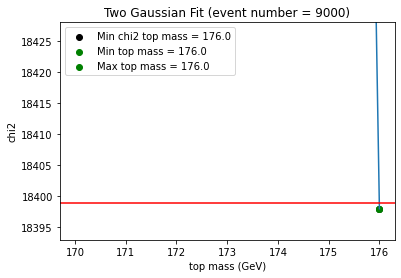

In [47]:
plt.plot(top_mass_arr, chi2_spanet_arr)
min_loc = [top_mass_arr[np.argmin(chi2_spanet_arr)], min(chi2_spanet_arr)]
passed_chi2_spanet_arr = [chi2 for chi2 in chi2_spanet_arr if chi2 < min(chi2_spanet_arr)+1]
plt.scatter(min_loc[0], min_loc[1], c='k', label = 'Min chi2 top mass = {}'.format(round(min_loc[0], 2)))
plt.scatter(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])], passed_chi2_spanet_arr[0], c='g', label='Min top mass = {}'.format(round(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[0])], 2)))
plt.scatter(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])], passed_chi2_spanet_arr[0], c='g', label='Max top mass = {}'.format(round(top_mass_arr[chi2_spanet_arr.index(passed_chi2_spanet_arr[-1])], 2)))
plt.axhline(min(chi2_spanet_arr)+1, c='r')
plt.ylim(min(chi2_spanet_arr)-5, min(chi2_spanet_arr)+30)
plt.title('Two Gaussian Fit (event number = {})'.format(len(chi2_target)))
plt.xlabel('top mass (GeV)')
plt.ylabel('chi2')
plt.legend()
plt.show()